In [1]:
%reload_ext autoreload
%autoreload 2

In [147]:
import gc

from argparse import Namespace
from mimetypes import suffix_map
from pathlib import Path
import numpy as np
import yaml
import torch

from pytorch_lightning.trainer import Trainer, seed_everything
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

from kolmopy.dataloaders import TurboFlowDataModule
import kolmopy.utils.viz_utils as viz
import kolmopy.utils.phy_utils as phy
import turboflow.utils.torch_utils as tch
from turboflow.utils.torch_utils import to_np

import matplotlib.pyplot as plt

In [20]:
exp_name = 'moMFN'
data_name = 'Synth2D_0003'
base_dir = Path('/','home','dicarlo_d','Documents','Code','TurboSuperResultion','recipes',exp_name)
data_dir = Path('/','home','dicarlo_d','Documents','Code','TurboSuperResultion','.cache', f'{data_name}.hdf5')
mdl_dir = base_dir / Path('models')
fig_dir = base_dir / Path('figures')
res_dir = base_dir / Path('results')

print(base_dir.exists())
print(data_dir.exists())

print(fig_dir.exists())
print(res_dir.exists())
print(res_dir.exists())

True
True
True
True
True


In [21]:
seed = 666
seed_everything(seed, workers=True)

# train
batch_size = {
    'train' : 64*64
,   'val'   : 64*64
,   'test'  : 64*64
}
dx = {
    'train' : 4
,   'val'   : 2
,   'test'  : 1
}
dt = {
    'train' : 1
,   'val'   : 1
,   'test'  : 1
}
time_idxs = np.array([15]) #np.array([0, 10, 20, 30])

Global seed set to 666


(128, 128, 2)
(128, 128, 2)
Low passing with scale: 16
Low passing with scale: 32
Low passing with scale: 64
Low passing with scale: 128


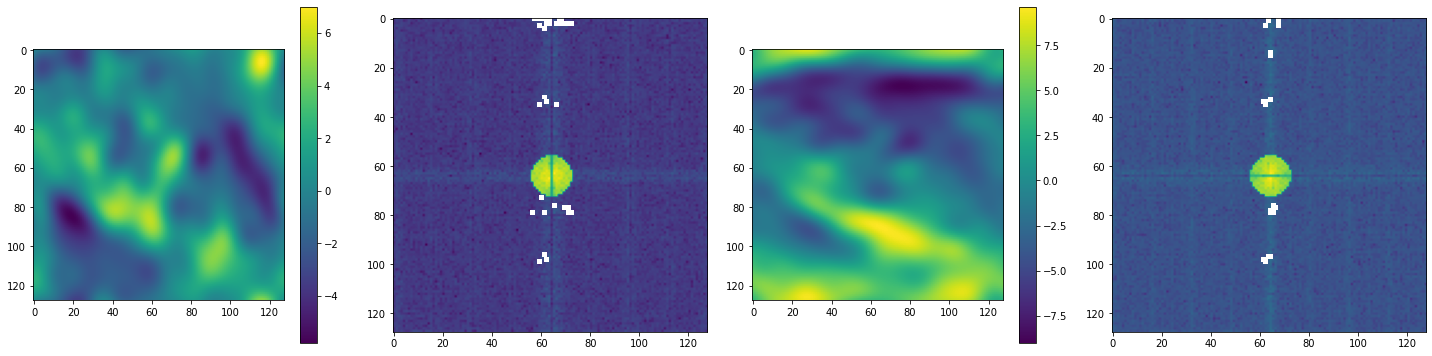

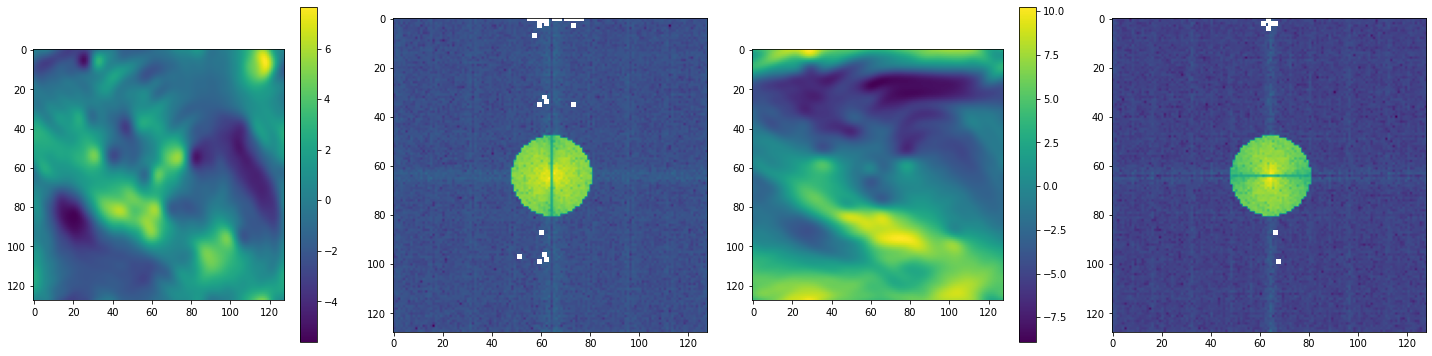

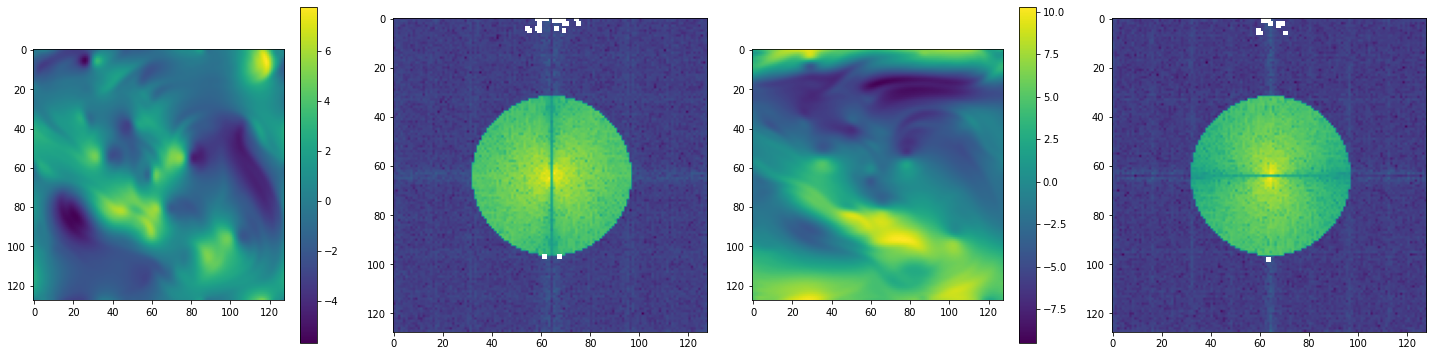

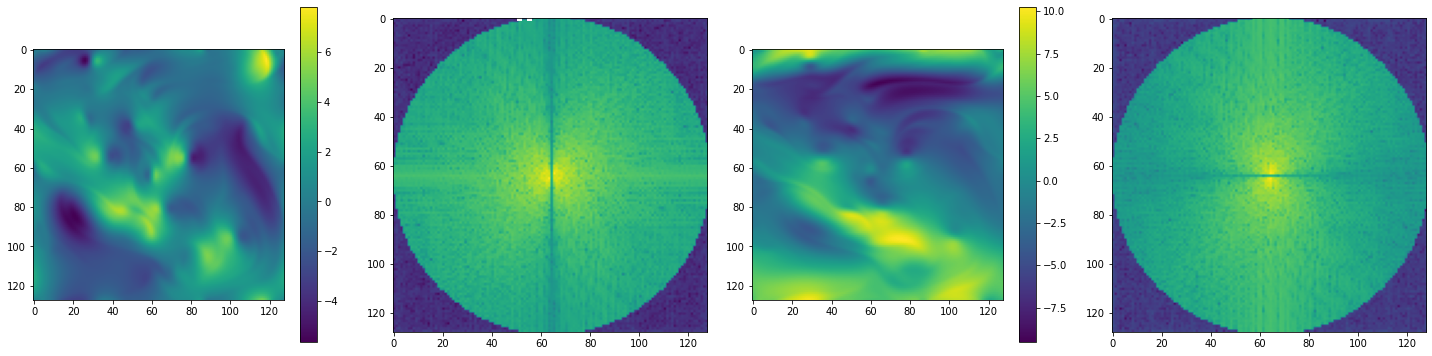

(256, 256, 2)
(256, 256, 2)
Low passing with scale: 32
Low passing with scale: 64
Low passing with scale: 128
Low passing with scale: 256


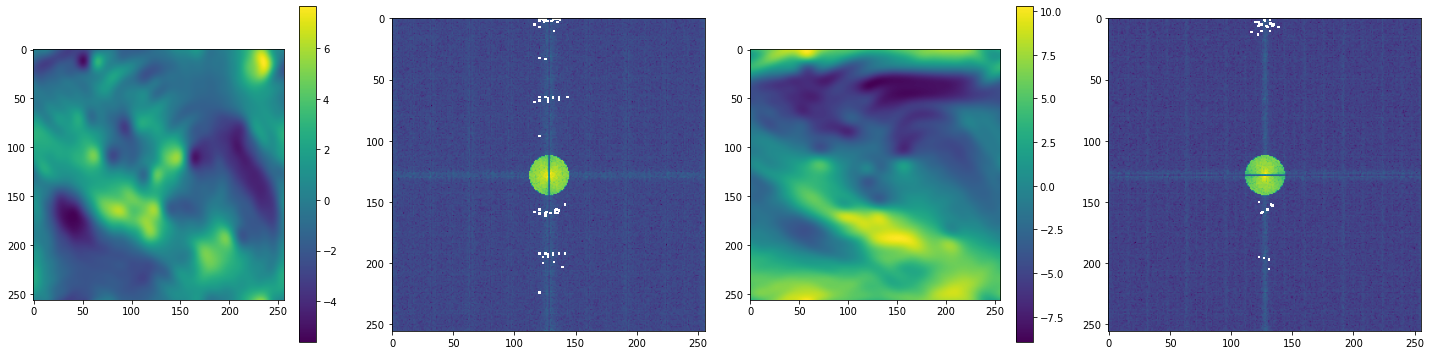

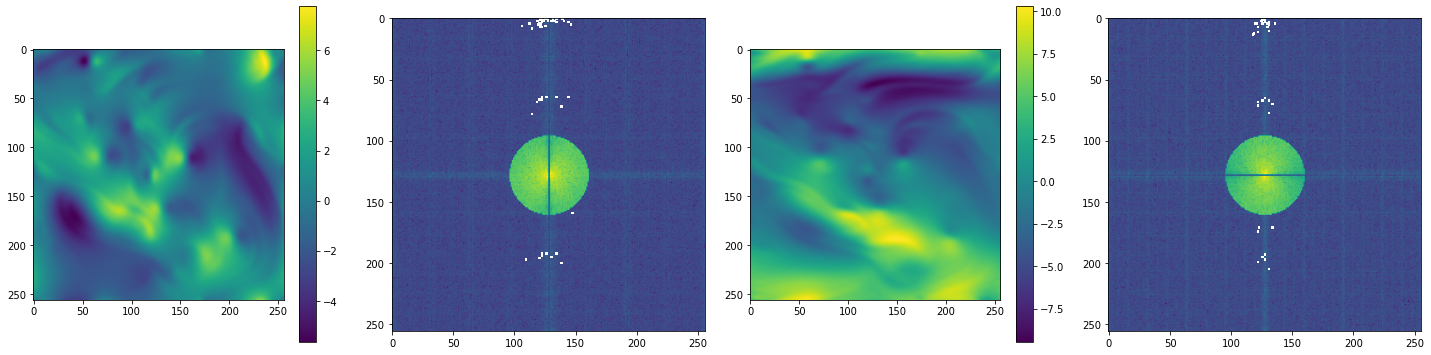

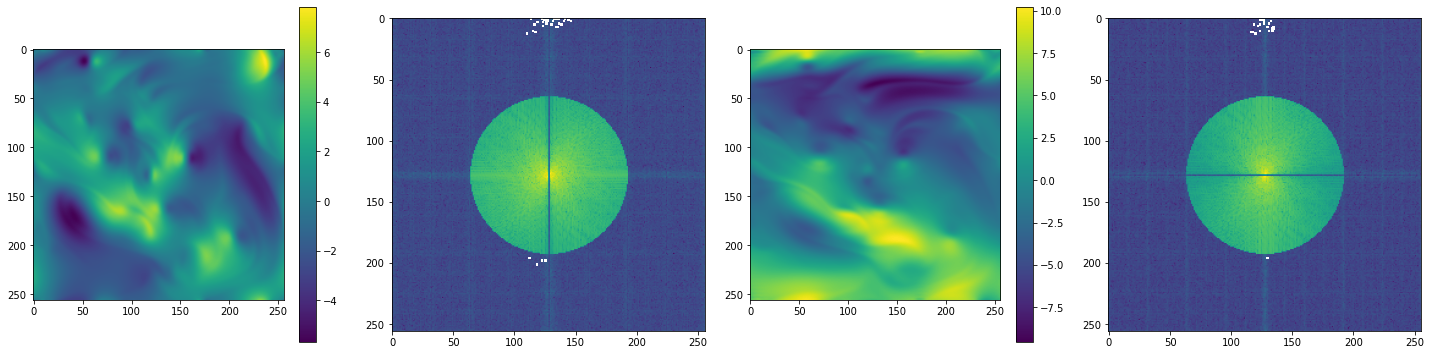

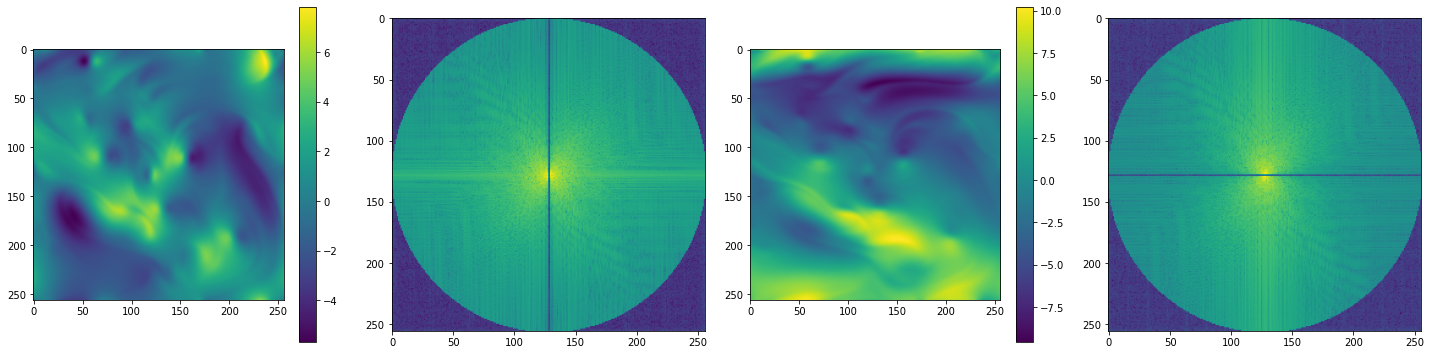

(512, 512, 2)
(512, 512, 2)
Low passing with scale: 64
Low passing with scale: 128
Low passing with scale: 256
Low passing with scale: 512


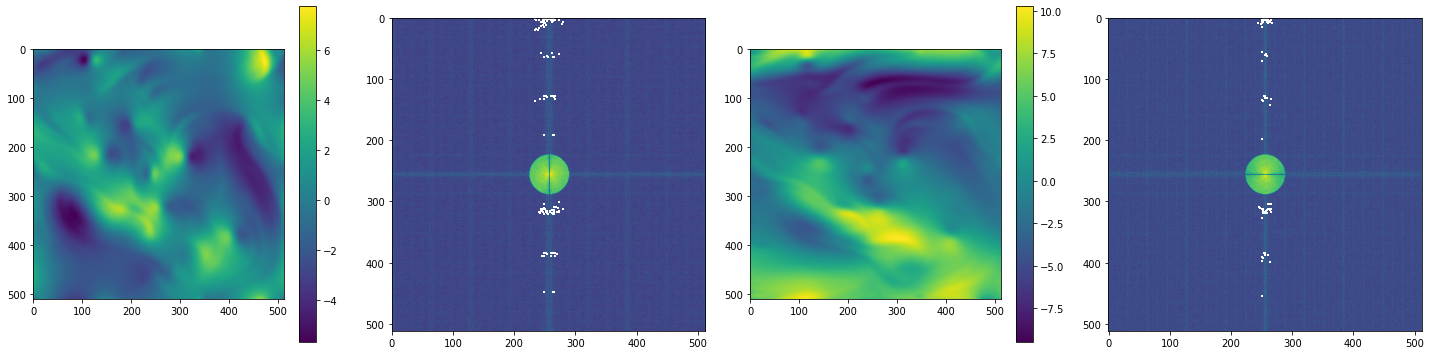

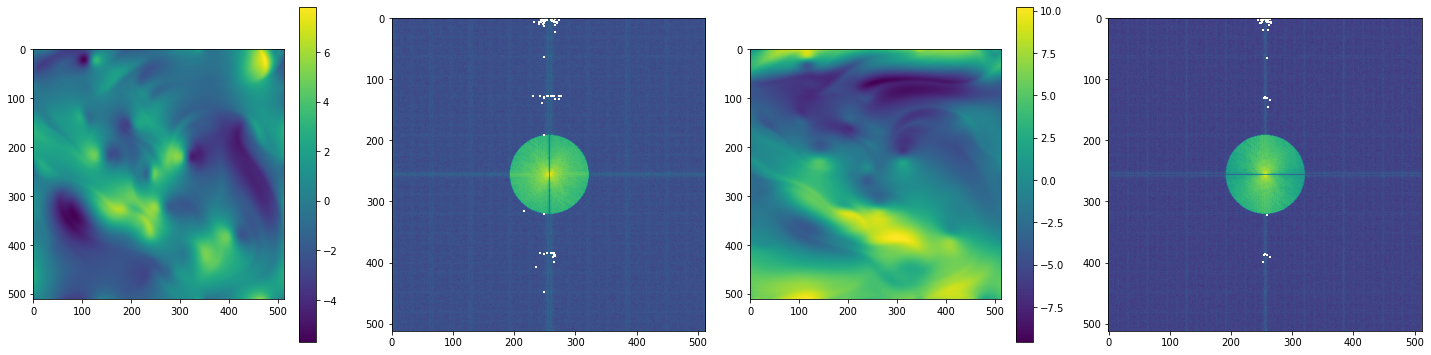

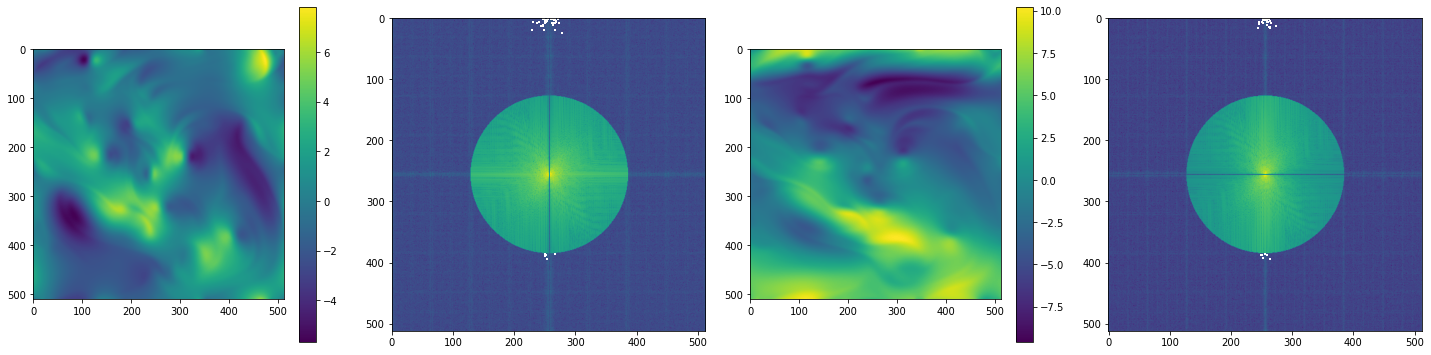

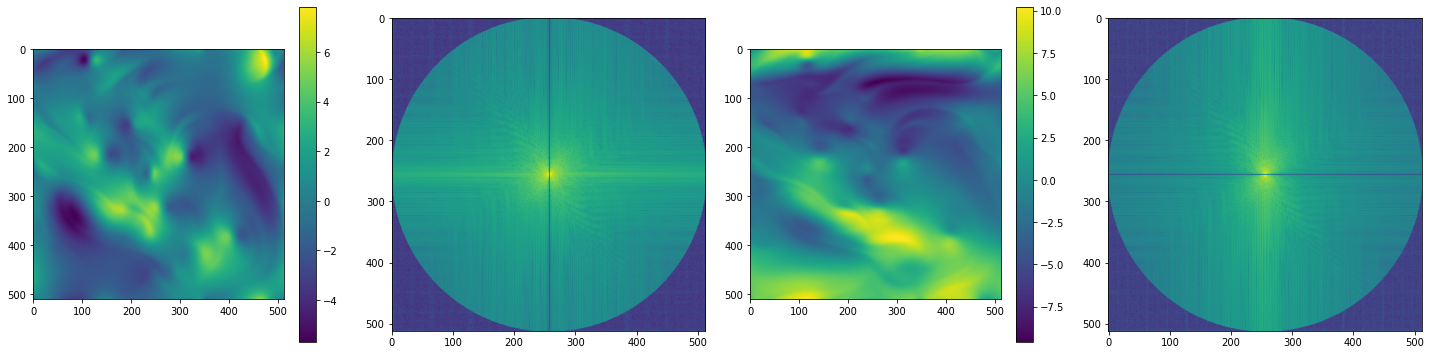

torch.Size([16384, 2]) torch.Size([16384, 2]) (128, 2) (128, 128, 2) (128, 128, 2)
0.0006832738423966522
0.5


In [24]:
# load dataset for TRAIN
dataset_name = 'Synth2D'
dm_train = TurboFlowDataModule(
    dataset=dataset_name, 
    data_dir=data_dir,
    time_idx=time_idxs,

    train_batch_size=batch_size['train'],
    val_batch_size=batch_size['val'],
    test_batch_size=batch_size['test'],

    train_downsampling_space=dx['train'],
    val_downsampling_space=dx['val'],
    test_downsampling_space=dx['test'],

    train_downsampling_time=dt['train'],
    val_downsampling_time=dt['val'],
    test_downsampling_time=dt['test'],

    train_shuffle=True,
    val_shuffle=False,
    test_shuffle=False,
    num_workers=8)

dm_train.setup()

# datasets = [dm_train.train_dataset, dm_train.val_dataset]
datasets = [dm_train.train_dataset]
for dataset in datasets:
    X, y, extra = dataset[:]
#     print(X.min(dim=0), X.max(dim=0))
    print(X.shape, y.shape, dataset.img_shape, dataset.vars_shape_img, dataset.fields_shape_img)
    print(dataset.diffusion)
    print(dataset.ax_t)

torch.Size([512, 512, 2])


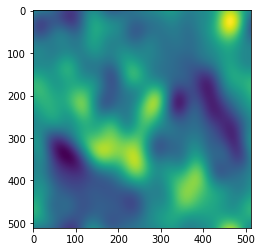

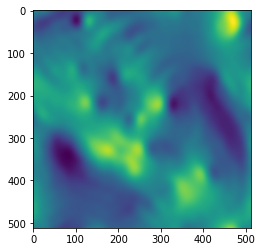

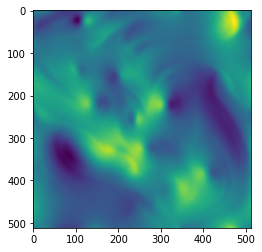

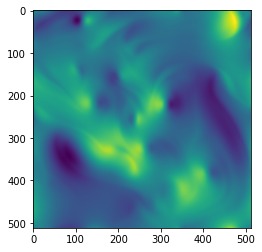

In [154]:
dataset = dm_train.test_dataset

vshape = dataset.vars_shape_img
fshape = dataset.fields_shape_img

txy, uv, uv_mid = dataset[:]

TXY = txy.reshape(*vshape)
UV = uv.reshape(*fshape)

print(UV.shape)
UV32 = phy.lowpass_filter(UV, 512/32)
UV16 = phy.lowpass_filter(UV, 512/16)
UV8 = phy.lowpass_filter(UV, 512/8)
UV1 = phy.lowpass_filter(UV, 512/1)

# UV32 = phy.resize(UV, 1/32)
# UV16 = phy.resize(UV, 1/16)
# UV8 = phy.resize(UV, 1/8)
# UV1 = phy.resize(UV, 1/1)


plt.imshow(UV32[:,:,0])
plt.show()
plt.imshow(UV16[:,:,0])
plt.show()
plt.imshow(UV8[:,:,0])
plt.show()
plt.imshow(UV1[:,:,0])
plt.show()

# path_to_spec = Path(f'../recipes/moMFN/{data_name}_spec_512.tch')
# torch.save(Ek, path_to_spec)
# Ek = torch.load(path_to_spec)

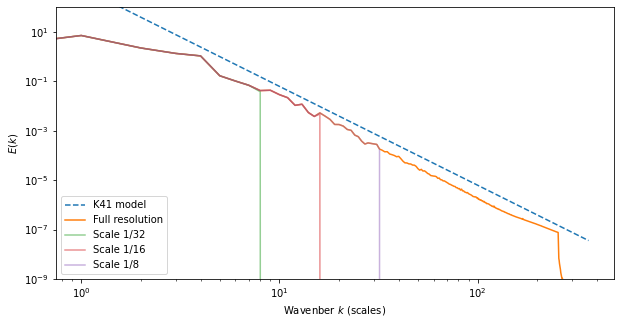

In [155]:
Ek, k = phy.energy_spectrum(UV[None,...])
Ek1, k = phy.energy_spectrum(UV32[None,...])
Ek2, k = phy.energy_spectrum(UV16[None,...])
Ek3, k = phy.energy_spectrum(UV8[None,...])

Ek[Ek<1e-13] = 0
Ek1[Ek1<1e-13] = 0
Ek2[Ek2<1e-13] = 0
Ek3[Ek3<1e-13] = 0

K41 = (0.2*k)**(-4)


plt.figure(figsize=(10,5))
plt.loglog(k, K41, '--', label='K41 model')
plt.loglog(k, Ek, label='Full resolution')
plt.loglog(k, Ek1, alpha=0.5, label='Scale 1/32')
plt.loglog(k, Ek2, alpha=0.5, label='Scale 1/16') 
plt.loglog(k, Ek3, alpha=0.5, label='Scale 1/8')
# plt.axvline(x=256)
plt.ylim([1e-9,1e2])
plt.ylabel(r'$E(k)$')
plt.xlabel(r'Wavenber $k$ (scales)')
plt.legend(loc='lower left')
plt.savefig('./figures/full_res_spec.png', dpi=300)
plt.show()

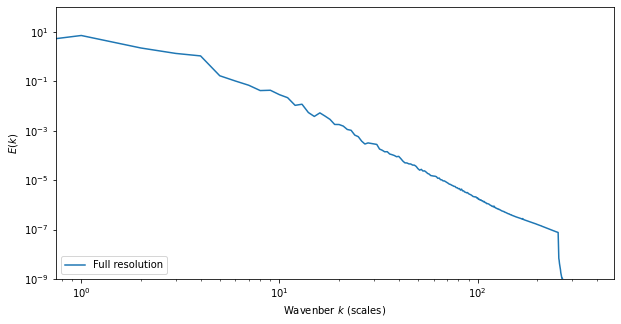

In [156]:
plt.figure(figsize=(10,5))
plt.loglog(k, Ek, label='Full resolution')
# plt.axvline(x=256)
plt.ylim([1e-9,1e2])
plt.ylabel(r'$E(k)$')
plt.xlabel(r'Wavenber $k$ (scales)')
plt.legend(loc='lower left')
plt.savefig('./figures/full_res_spec.png', dpi=300)
plt.show()

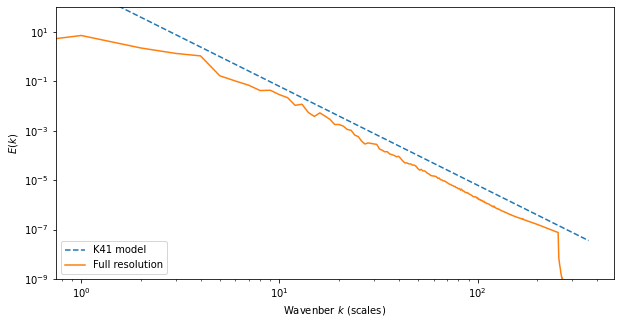

In [157]:
plt.figure(figsize=(10,5))
plt.loglog(k, K41, '--', label='K41 model')
plt.loglog(k, Ek, label='Full resolution')
# plt.axvline(x=256)
plt.ylim([1e-9,1e2])
plt.ylabel(r'$E(k)$')
plt.xlabel(r'Wavenber $k$ (scales)')
plt.legend(loc='lower left')
plt.savefig('./figures/full_res_spec.png', dpi=300)
plt.show()

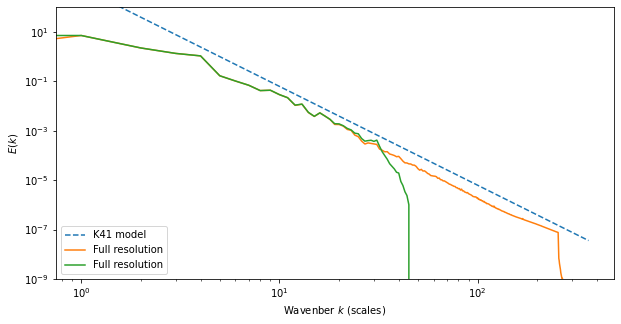

In [161]:
from scipy.interpolate import interp2d

UVint = torch.zeros_like(UV)
UVdown = UV[::8,::8,:]

for i in [0,1]:
    U=UVdown[...,i].numpy()

    x = np.linspace(-1,1,64)
    y = np.linspace(-1,1,64)

    interp = interp2d(x, y, U)

    x = np.linspace(-1,1,512)
    y = np.linspace(-1,1,512)

    UVint[:,:,i] = torch.from_numpy(interp(x, y))
    
Ek_down, k_down = phy.energy_spectrum(UVdown[None,...])
Ek_int, k = phy.energy_spectrum(UVint[None,...])

plt.figure(figsize=(10,5))
plt.loglog(k, K41, '--', label='K41 model')
plt.loglog(k, Ek, label='Full resolution')
plt.loglog(k_down, Ek_down, label='Full resolution')
# plt.loglog(k, Ek_int, label='Inteprolated')
# plt.axvline(x=256)
plt.ylim([1e-9,1e2])
plt.ylabel(r'$E(k)$')
plt.xlabel(r'Wavenber $k$ (scales)')
plt.legend(loc='lower left')
plt.savefig('./figures/full_res_spec_lr_hr.png', dpi=300)
plt.show()

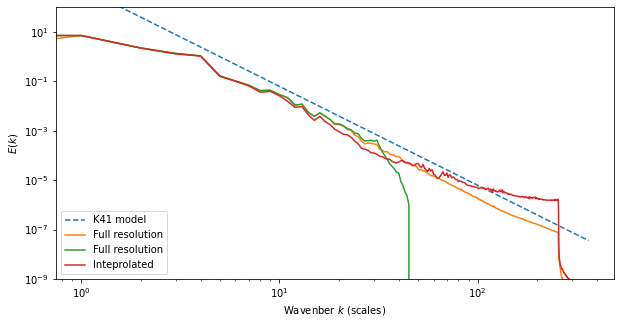

In [162]:
from scipy.interpolate import interp2d

UVint = torch.zeros_like(UV)
UVdown = UV[::8,::8,:]

for i in [0,1]:
    U=UVdown[...,i].numpy()

    x = np.linspace(-1,1,64)
    y = np.linspace(-1,1,64)

    interp = interp2d(x, y, U)

    x = np.linspace(-1,1,512)
    y = np.linspace(-1,1,512)

    UVint[:,:,i] = torch.from_numpy(interp(x, y))
    
Ek_down, k_down = phy.energy_spectrum(UVdown[None,...])
Ek_int, k = phy.energy_spectrum(UVint[None,...])

plt.figure(figsize=(10,5))
plt.loglog(k, K41, '--', label='K41 model')
plt.loglog(k, Ek, label='Full resolution')
plt.loglog(k_down, Ek_down, label='Full resolution')
plt.loglog(k, Ek_int, label='Inteprolated')
# plt.axvline(x=256)
plt.ylim([1e-9,1e2])
plt.ylabel(r'$E(k)$')
plt.xlabel(r'Wavenber $k$ (scales)')
plt.legend(loc='lower left')
plt.savefig('./figures/full_res_spec_interp.png', dpi=300)
plt.show()

In [7]:
# dataset = dm_train.train_dataset

# vshape = dataset.vars_shape_img
# fshape = dataset.fields_shape_img

# txy, uv, uv_mid = dataset[:]

# TXY = txy.reshape(*vshape).numpy()
# UV = uv.reshape(*fshape).numpy()
# XY = TXY[0,:,:,1:]

In [8]:
# dataset = dm_train.train_dataset

# vshape = dataset.vars_shape_img
# fshape = dataset.fields_shape_img

# txy, uv, uv_mid = dataset[:]

# TXY = txy.reshape(*vshape).numpy()
# UV = uv.reshape(*fshape).numpy()
# XY = TXY[0,:,:,1:]

# plt.figure(figsize=(20,4))
# plt.subplot(141)
# plt.imshow(TXY[0,:,:,1])
# plt.colorbar()
# plt.subplot(142)
# plt.imshow(TXY[0,:,:,2])
# plt.colorbar()
# plt.subplot(143)
# plt.imshow(UV[0,:,:,0])
# plt.colorbar()
# plt.subplot(144)
# plt.imshow(UV[0,:,:,1])
# plt.colorbar()
# plt.show()

# UV1 = UV[0,:,:,:]
# UV2 = UV[1,:,:,:]
# dt = TXY[1,0,0,0] - TXY[0,0,0,0]
# print(dt)

# D1 = phy.compute_divergence(XY, UV1)
# D2 = phy.compute_divergence(XY, UV2)

# plt.figure(figsize=(10,4))
# plt.subplot(121)
# plt.imshow(D1)
# plt.colorbar()
# plt.subplot(122)
# plt.imshow(D2)
# plt.colorbar()
# plt.show()

# W1 = phy.compute_vorticity(XY, UV1)
# W2 = phy.compute_vorticity(XY, UV2)

# plt.figure(figsize=(10,4))
# plt.subplot(121)
# plt.imshow(W1)
# plt.colorbar()
# plt.subplot(122)
# plt.imshow(W2)
# plt.colorbar()
# plt.show()

# W_t = (W2 - W1)/dt
# plt.imshow(W_t)
# plt.colorbar()
# plt.show()

# [W_x, W_y] = phy.my_grad([W1],[XY[:,0,0], XY[0,:,1]], indexing='ij')[0]

# W_a = W_x * UV1[:,:,0] + W_y * UV1[:,:,1]

# plt.imshow(W_a)
# plt.colorbar()
# plt.show()

# plt.imshow(W_t + W_a)
# plt.colorbar()
# plt.show()